In [1]:
#Short term fluctuations
!pip install pandas_datareader
!pip install google-api-python-client
!pip install yfinance
!pip install xgboost
!pip install ta
import ta
import pandas as pd
import requests
import time
import pandas_datareader.data as web
import datetime
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import xgboost as xgb
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'
import yfinance as yfin
yfin.pdr_override()

In [5]:
df = yfin.download("GOOGL", start="2013-01-01", end=datetime.datetime.now())
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,18.003504,18.193193,17.931683,18.099348,18.099348,101550348
2013-01-03,18.141392,18.316566,18.036036,18.109859,18.109859,92635272
2013-01-04,18.251753,18.555305,18.210211,18.467718,18.467718,110429460
2013-01-07,18.404655,18.503002,18.282784,18.387136,18.387136,66161772
2013-01-08,18.406906,18.425926,18.128880,18.350851,18.350851,66976956
...,...,...,...,...,...,...
2023-05-30,125.639999,125.660004,122.000000,123.669998,123.669998,35076700
2023-05-31,122.750000,124.059998,122.500000,122.870003,122.870003,37325800
2023-06-01,122.820000,124.419998,122.620003,123.720001,123.720001,30772700


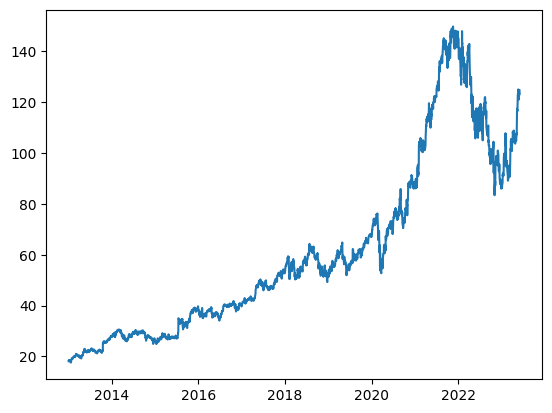

In [73]:
#Plot the closing price of Google (or whichever one)
plt.plot(df['Close'])

In [7]:
df['Return'] = df['Adj Close'].pct_change(60).shift(-60)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
df['SMA'] = df['Close'].rolling(window=20).mean()  
df['MACD'] = ta.trend.MACD(df['Close']).macd()   
list_of_features = ['High', 'Low', 'Close', 'Volume', 'Adj Close', 'SMA', 'RSI', 'MACD']
X = df[list_of_features]

y = np.where(df.Return > 0, 1, 0)
#df

In [8]:
#split data to see how good the decision tree will be
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 500)
#print sizes of the data
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

In [9]:
#treeClassifier = DecisionTreeClassifier('entropy', max_depth=4, min_samples_leaf=7)
#treeClassifier.fit(X_train, y_train)
xgb_Classifier = xgb.XGBClassifier(max_depth=3)
xgb_Classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [10]:
#y_pred = tree_Classifier.predict(X_test)
y_pred = xgb_Classifier.predict(X_test)

In [12]:
#Check performances
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       298
           1       0.87      0.91      0.89       490

    accuracy                           0.86       788
   macro avg       0.85      0.84      0.85       788
weighted avg       0.86      0.86      0.86       788



<Figure size 2400x5000 with 0 Axes>

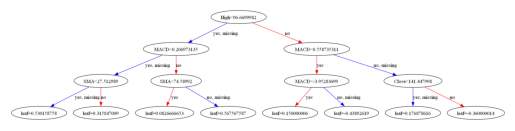

In [13]:
#View Tree
from sklearn import tree
import graphviz

plt.figure(figsize=(24, 50))
# Visualize a single tree using xgb.plot_tree()
xgb.plot_tree(xgb_Classifier, num_trees=0, max_depth=3)
plt.show()